# Convolutional Neural Network to achieve image classification.

### Libraries Required

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available")
else:
    print("CUDA is available. Training will be conducted on GPU....")



cuda:0
CUDA is available. Training will be conducted on GPU....


### Obtaining Data from CIFAR-10 database

In [24]:
num_workers = 0
batch_size = 4
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
training_data = datasets.CIFAR10("CIFAR",train = True, download=True, transform = transform)
testing_data = datasets.CIFAR10("CIFAR",train = False, download=True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


### Creating Training and Testing datasets

In [25]:
trainset = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
testset = torch.utils.data.DataLoader(testing_data, batch_size=batch_size,
                                          shuffle=False, num_workers=num_workers)

classes = ['plane', 'car', 'bird', 'cat','deer','dog', 'frog', 'horse', 'ship', 'truck']

In [26]:
# Checking out how the training data looks in a pytorch Tensor
print("Number of images in Training dataset = ", len(training_data))
print("Number of images in Test dataset = ",len(testing_data))
for train_data in trainset:
    print("Glimpse of Training data tensors",train_data)
    break

Number of images in Training dataset =  50000
Number of images in Test dataset =  10000
Glimpse of Training data tensors [tensor([[[[-0.4275, -0.6392, -0.5686,  ..., -0.1686, -0.2627, -0.2157],
          [-0.5216, -0.5451, -0.3333,  ..., -0.1294, -0.2941, -0.2235],
          [-0.6392, -0.5922, -0.4667,  ...,  0.0275, -0.1686, -0.0980],
          ...,
          [ 0.3490,  0.3255,  0.3333,  ...,  0.2235,  0.1843,  0.1765],
          [ 0.2863,  0.2627,  0.2392,  ...,  0.2235,  0.1843,  0.1686],
          [ 0.2157,  0.1373,  0.0745,  ...,  0.2314,  0.2078,  0.1843]],

         [[-0.1922, -0.4039, -0.3333,  ..., -0.0196, -0.2078, -0.2000],
          [-0.2941, -0.3255, -0.1216,  ...,  0.0118, -0.2314, -0.2078],
          [-0.4275, -0.3804, -0.2627,  ...,  0.1765, -0.1059, -0.0824],
          ...,
          [ 0.7961,  0.7647,  0.7804,  ...,  0.6863,  0.6392,  0.6471],
          [ 0.7490,  0.7176,  0.6941,  ...,  0.6549,  0.6235,  0.6392],
          [ 0.6706,  0.5922,  0.5373,  ...,  0.6549,  

In [27]:
# Printing few samples of Training dataset images
def view_sample_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

### Sample Images from Training Set

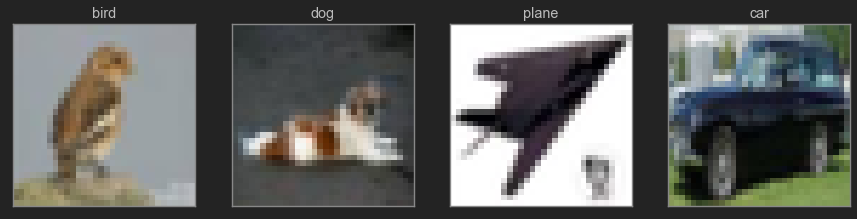

In [29]:
sampledata = iter(trainset)
images, labels = sampledata.next()

fig = plt.figure(figsize=(15,20))
for i in np.arange(4):
    ax = fig.add_subplot(1,4, i+1, xticks = [], yticks = [])
    view_sample_image(images[i])
    ax.set_title(classes[labels[i]])

In [30]:
print("Shape of the images",images.shape)
print("Shape of the labels",labels.shape)

Shape of the images torch.Size([4, 3, 32, 32])
Shape of the labels torch.Size([4])


### Creating the Neural Network

Input > Conv (ReLU) > MaxPool > Conv (ReLU) > MaxPool > FC (ReLU) > FC (ReLU) > FC (SoftMax) > 10 outputs

Conv is a convolutional layer, ReLU is the activation function, MaxPool is a pooling layer, FC is a fully connected layer and SoftMax is the activation function of the output layer.

In [31]:
class CIFARNET(nn.Module):
    def __init__(self):
        super(CIFARNET,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = CIFARNET().to(device)

In [32]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.5)

### Function for training the model

In [33]:
training_losses = []
training_counter = []

In [34]:
def training(epoch):
    model.train()
    for i, (images, labels) in enumerate(trainset):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}' .format
                   (epoch+1, i * len(images), len(trainset.dataset),
                    100. * i / len(trainset), loss.item()))
            
            training_losses.append(loss.item())
            training_counter.append((i*100) + ((epoch-1)*len(trainset.dataset)))
    print('Finished Training')

In [35]:
def testing():
    model.eval()
    correct = 0    
    testing_losses = 0
    total = 0
    with torch.no_grad():
        
        for images, labels in testset:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            testing_losses += loss_function(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct +=  (predicted == labels).sum().item()

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        testing_losses, correct, len(testset.dataset),
        100. * correct / len(testset.dataset)))

### Training and Testing the model

In [36]:
for epoch in range(10):
    training(epoch)
    testing()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.286747
Train Epoch: 1 [400/50000 (1%)]	Loss: 2.324036
Train Epoch: 1 [800/50000 (2%)]	Loss: 2.319389
Train Epoch: 1 [1200/50000 (2%)]	Loss: 2.311347
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.262020
Train Epoch: 1 [2000/50000 (4%)]	Loss: 2.311767
Train Epoch: 1 [2400/50000 (5%)]	Loss: 2.308915
Train Epoch: 1 [2800/50000 (6%)]	Loss: 2.317431
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.328286
Train Epoch: 1 [3600/50000 (7%)]	Loss: 2.320588
Train Epoch: 1 [4000/50000 (8%)]	Loss: 2.302807
Train Epoch: 1 [4400/50000 (9%)]	Loss: 2.329659
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2.258182
Train Epoch: 1 [5200/50000 (10%)]	Loss: 2.325201
Train Epoch: 1 [5600/50000 (11%)]	Loss: 2.298045
Train Epoch: 1 [6000/50000 (12%)]	Loss: 2.280454
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.288249
Train Epoch: 1 [6800/50000 (14%)]	Loss: 2.312693
Train Epoch: 1 [7200/50000 (14%)]	Loss: 2.341489
Train Epoch: 1 [7600/50000 (15%)]	Loss: 2.317122
Train Epoch: 1 [8000/50000 (16%)]	Los

Train Epoch: 2 [15600/50000 (31%)]	Loss: 1.497215
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.217961
Train Epoch: 2 [16400/50000 (33%)]	Loss: 2.160719
Train Epoch: 2 [16800/50000 (34%)]	Loss: 1.226887
Train Epoch: 2 [17200/50000 (34%)]	Loss: 2.184003
Train Epoch: 2 [17600/50000 (35%)]	Loss: 1.026270
Train Epoch: 2 [18000/50000 (36%)]	Loss: 2.093635
Train Epoch: 2 [18400/50000 (37%)]	Loss: 2.004719
Train Epoch: 2 [18800/50000 (38%)]	Loss: 2.172951
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.440699
Train Epoch: 2 [19600/50000 (39%)]	Loss: 2.162099
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.588970
Train Epoch: 2 [20400/50000 (41%)]	Loss: 1.490960
Train Epoch: 2 [20800/50000 (42%)]	Loss: 1.873925
Train Epoch: 2 [21200/50000 (42%)]	Loss: 1.623530
Train Epoch: 2 [21600/50000 (43%)]	Loss: 1.551540
Train Epoch: 2 [22000/50000 (44%)]	Loss: 1.342146
Train Epoch: 2 [22400/50000 (45%)]	Loss: 1.491394
Train Epoch: 2 [22800/50000 (46%)]	Loss: 1.561371
Train Epoch: 2 [23200/50000 (46%)]	Loss: 1.599633


Train Epoch: 3 [31200/50000 (62%)]	Loss: 1.411875
Train Epoch: 3 [31600/50000 (63%)]	Loss: 1.315820
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.076085
Train Epoch: 3 [32400/50000 (65%)]	Loss: 1.302975
Train Epoch: 3 [32800/50000 (66%)]	Loss: 1.987723
Train Epoch: 3 [33200/50000 (66%)]	Loss: 2.381788
Train Epoch: 3 [33600/50000 (67%)]	Loss: 0.975753
Train Epoch: 3 [34000/50000 (68%)]	Loss: 0.897151
Train Epoch: 3 [34400/50000 (69%)]	Loss: 2.212800
Train Epoch: 3 [34800/50000 (70%)]	Loss: 1.321541
Train Epoch: 3 [35200/50000 (70%)]	Loss: 1.779696
Train Epoch: 3 [35600/50000 (71%)]	Loss: 1.128952
Train Epoch: 3 [36000/50000 (72%)]	Loss: 1.870729
Train Epoch: 3 [36400/50000 (73%)]	Loss: 0.922296
Train Epoch: 3 [36800/50000 (74%)]	Loss: 1.982045
Train Epoch: 3 [37200/50000 (74%)]	Loss: 0.622551
Train Epoch: 3 [37600/50000 (75%)]	Loss: 1.581846
Train Epoch: 3 [38000/50000 (76%)]	Loss: 0.942696
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.542325
Train Epoch: 3 [38800/50000 (78%)]	Loss: 0.978702


Train Epoch: 4 [46800/50000 (94%)]	Loss: 0.941290
Train Epoch: 4 [47200/50000 (94%)]	Loss: 1.548692
Train Epoch: 4 [47600/50000 (95%)]	Loss: 2.900646
Train Epoch: 4 [48000/50000 (96%)]	Loss: 2.080837
Train Epoch: 4 [48400/50000 (97%)]	Loss: 3.283735
Train Epoch: 4 [48800/50000 (98%)]	Loss: 1.125703
Train Epoch: 4 [49200/50000 (98%)]	Loss: 1.162405
Train Epoch: 4 [49600/50000 (99%)]	Loss: 1.160697
Finished Training

Test set: Avg. loss: 3225.5767, Accuracy: 5352/10000 (54%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.555771
Train Epoch: 5 [400/50000 (1%)]	Loss: 0.812227
Train Epoch: 5 [800/50000 (2%)]	Loss: 0.959918
Train Epoch: 5 [1200/50000 (2%)]	Loss: 1.085965
Train Epoch: 5 [1600/50000 (3%)]	Loss: 1.251146
Train Epoch: 5 [2000/50000 (4%)]	Loss: 1.289710
Train Epoch: 5 [2400/50000 (5%)]	Loss: 0.510426
Train Epoch: 5 [2800/50000 (6%)]	Loss: 1.333982
Train Epoch: 5 [3200/50000 (6%)]	Loss: 0.393908
Train Epoch: 5 [3600/50000 (7%)]	Loss: 0.519017
Train Epoch: 5 [4000/50000 (8%)]	Loss: 0.66085

Train Epoch: 6 [12000/50000 (24%)]	Loss: 1.825093
Train Epoch: 6 [12400/50000 (25%)]	Loss: 1.558663
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.872933
Train Epoch: 6 [13200/50000 (26%)]	Loss: 0.837726
Train Epoch: 6 [13600/50000 (27%)]	Loss: 0.655986
Train Epoch: 6 [14000/50000 (28%)]	Loss: 1.008684
Train Epoch: 6 [14400/50000 (29%)]	Loss: 1.856378
Train Epoch: 6 [14800/50000 (30%)]	Loss: 1.155279
Train Epoch: 6 [15200/50000 (30%)]	Loss: 1.047054
Train Epoch: 6 [15600/50000 (31%)]	Loss: 1.323682
Train Epoch: 6 [16000/50000 (32%)]	Loss: 1.200694
Train Epoch: 6 [16400/50000 (33%)]	Loss: 2.112131
Train Epoch: 6 [16800/50000 (34%)]	Loss: 0.984649
Train Epoch: 6 [17200/50000 (34%)]	Loss: 0.789239
Train Epoch: 6 [17600/50000 (35%)]	Loss: 0.913280
Train Epoch: 6 [18000/50000 (36%)]	Loss: 0.595105
Train Epoch: 6 [18400/50000 (37%)]	Loss: 1.250225
Train Epoch: 6 [18800/50000 (38%)]	Loss: 0.934738
Train Epoch: 6 [19200/50000 (38%)]	Loss: 0.666453
Train Epoch: 6 [19600/50000 (39%)]	Loss: 1.836163


Train Epoch: 7 [27600/50000 (55%)]	Loss: 0.053799
Train Epoch: 7 [28000/50000 (56%)]	Loss: 1.600414
Train Epoch: 7 [28400/50000 (57%)]	Loss: 1.094709
Train Epoch: 7 [28800/50000 (58%)]	Loss: 1.234152
Train Epoch: 7 [29200/50000 (58%)]	Loss: 0.961003
Train Epoch: 7 [29600/50000 (59%)]	Loss: 1.179929
Train Epoch: 7 [30000/50000 (60%)]	Loss: 0.861442
Train Epoch: 7 [30400/50000 (61%)]	Loss: 1.399878
Train Epoch: 7 [30800/50000 (62%)]	Loss: 0.289769
Train Epoch: 7 [31200/50000 (62%)]	Loss: 1.613546
Train Epoch: 7 [31600/50000 (63%)]	Loss: 1.391024
Train Epoch: 7 [32000/50000 (64%)]	Loss: 2.851732
Train Epoch: 7 [32400/50000 (65%)]	Loss: 1.689213
Train Epoch: 7 [32800/50000 (66%)]	Loss: 0.397332
Train Epoch: 7 [33200/50000 (66%)]	Loss: 0.951177
Train Epoch: 7 [33600/50000 (67%)]	Loss: 1.386679
Train Epoch: 7 [34000/50000 (68%)]	Loss: 1.618755
Train Epoch: 7 [34400/50000 (69%)]	Loss: 1.128023
Train Epoch: 7 [34800/50000 (70%)]	Loss: 0.941359
Train Epoch: 7 [35200/50000 (70%)]	Loss: 1.413646


Train Epoch: 8 [43200/50000 (86%)]	Loss: 2.624480
Train Epoch: 8 [43600/50000 (87%)]	Loss: 0.327114
Train Epoch: 8 [44000/50000 (88%)]	Loss: 1.795282
Train Epoch: 8 [44400/50000 (89%)]	Loss: 1.135702
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.737328
Train Epoch: 8 [45200/50000 (90%)]	Loss: 1.322258
Train Epoch: 8 [45600/50000 (91%)]	Loss: 1.716853
Train Epoch: 8 [46000/50000 (92%)]	Loss: 1.045068
Train Epoch: 8 [46400/50000 (93%)]	Loss: 0.863762
Train Epoch: 8 [46800/50000 (94%)]	Loss: 1.505868
Train Epoch: 8 [47200/50000 (94%)]	Loss: 1.450251
Train Epoch: 8 [47600/50000 (95%)]	Loss: 0.714737
Train Epoch: 8 [48000/50000 (96%)]	Loss: 0.563247
Train Epoch: 8 [48400/50000 (97%)]	Loss: 0.894175
Train Epoch: 8 [48800/50000 (98%)]	Loss: 1.481425
Train Epoch: 8 [49200/50000 (98%)]	Loss: 1.877410
Train Epoch: 8 [49600/50000 (99%)]	Loss: 2.266686
Finished Training

Test set: Avg. loss: 2921.4409, Accuracy: 5926/10000 (59%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.606907
Train Epoch: 9 [400/50000 

Train Epoch: 10 [8000/50000 (16%)]	Loss: 1.173292
Train Epoch: 10 [8400/50000 (17%)]	Loss: 0.264862
Train Epoch: 10 [8800/50000 (18%)]	Loss: 0.648020
Train Epoch: 10 [9200/50000 (18%)]	Loss: 0.131303
Train Epoch: 10 [9600/50000 (19%)]	Loss: 0.886576
Train Epoch: 10 [10000/50000 (20%)]	Loss: 0.719354
Train Epoch: 10 [10400/50000 (21%)]	Loss: 0.793373
Train Epoch: 10 [10800/50000 (22%)]	Loss: 0.529288
Train Epoch: 10 [11200/50000 (22%)]	Loss: 1.520664
Train Epoch: 10 [11600/50000 (23%)]	Loss: 1.259377
Train Epoch: 10 [12000/50000 (24%)]	Loss: 1.462934
Train Epoch: 10 [12400/50000 (25%)]	Loss: 0.872657
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.577098
Train Epoch: 10 [13200/50000 (26%)]	Loss: 1.468605
Train Epoch: 10 [13600/50000 (27%)]	Loss: 0.763225
Train Epoch: 10 [14000/50000 (28%)]	Loss: 0.680570
Train Epoch: 10 [14400/50000 (29%)]	Loss: 0.510863
Train Epoch: 10 [14800/50000 (30%)]	Loss: 1.269542
Train Epoch: 10 [15200/50000 (30%)]	Loss: 1.261391
Train Epoch: 10 [15600/50000 (31%)]	

Train Epoch: 11 [22400/50000 (45%)]	Loss: 1.663998
Train Epoch: 11 [22800/50000 (46%)]	Loss: 0.581712
Train Epoch: 11 [23200/50000 (46%)]	Loss: 0.584807
Train Epoch: 11 [23600/50000 (47%)]	Loss: 0.343635
Train Epoch: 11 [24000/50000 (48%)]	Loss: 0.741527
Train Epoch: 11 [24400/50000 (49%)]	Loss: 1.077291
Train Epoch: 11 [24800/50000 (50%)]	Loss: 2.078686
Train Epoch: 11 [25200/50000 (50%)]	Loss: 1.028263
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.644743
Train Epoch: 11 [26000/50000 (52%)]	Loss: 1.023316
Train Epoch: 11 [26400/50000 (53%)]	Loss: 1.043865
Train Epoch: 11 [26800/50000 (54%)]	Loss: 0.653679
Train Epoch: 11 [27200/50000 (54%)]	Loss: 1.233627
Train Epoch: 11 [27600/50000 (55%)]	Loss: 0.597265
Train Epoch: 11 [28000/50000 (56%)]	Loss: 1.006662
Train Epoch: 11 [28400/50000 (57%)]	Loss: 0.655191
Train Epoch: 11 [28800/50000 (58%)]	Loss: 1.193622
Train Epoch: 11 [29200/50000 (58%)]	Loss: 1.266934
Train Epoch: 11 [29600/50000 (59%)]	Loss: 0.872957
Train Epoch: 11 [30000/50000 (6

Train Epoch: 12 [36400/50000 (73%)]	Loss: 1.133245
Train Epoch: 12 [36800/50000 (74%)]	Loss: 0.619609
Train Epoch: 12 [37200/50000 (74%)]	Loss: 0.865275
Train Epoch: 12 [37600/50000 (75%)]	Loss: 1.585989
Train Epoch: 12 [38000/50000 (76%)]	Loss: 1.177534
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.516187
Train Epoch: 12 [38800/50000 (78%)]	Loss: 0.655531
Train Epoch: 12 [39200/50000 (78%)]	Loss: 0.349608
Train Epoch: 12 [39600/50000 (79%)]	Loss: 1.878600
Train Epoch: 12 [40000/50000 (80%)]	Loss: 0.621978
Train Epoch: 12 [40400/50000 (81%)]	Loss: 1.547773
Train Epoch: 12 [40800/50000 (82%)]	Loss: 0.389790
Train Epoch: 12 [41200/50000 (82%)]	Loss: 0.630642
Train Epoch: 12 [41600/50000 (83%)]	Loss: 0.585515
Train Epoch: 12 [42000/50000 (84%)]	Loss: 1.613502
Train Epoch: 12 [42400/50000 (85%)]	Loss: 0.882523
Train Epoch: 12 [42800/50000 (86%)]	Loss: 0.886952
Train Epoch: 12 [43200/50000 (86%)]	Loss: 1.255646
Train Epoch: 12 [43600/50000 (87%)]	Loss: 1.598071
Train Epoch: 12 [44000/50000 (8

Train Epoch: 14 [400/50000 (1%)]	Loss: 1.295878
Train Epoch: 14 [800/50000 (2%)]	Loss: 1.071425
Train Epoch: 14 [1200/50000 (2%)]	Loss: 0.608196
Train Epoch: 14 [1600/50000 (3%)]	Loss: 0.701451
Train Epoch: 14 [2000/50000 (4%)]	Loss: 0.980519
Train Epoch: 14 [2400/50000 (5%)]	Loss: 0.894838
Train Epoch: 14 [2800/50000 (6%)]	Loss: 1.136544
Train Epoch: 14 [3200/50000 (6%)]	Loss: 0.410343
Train Epoch: 14 [3600/50000 (7%)]	Loss: 0.578760
Train Epoch: 14 [4000/50000 (8%)]	Loss: 0.771813
Train Epoch: 14 [4400/50000 (9%)]	Loss: 0.942578
Train Epoch: 14 [4800/50000 (10%)]	Loss: 0.735685
Train Epoch: 14 [5200/50000 (10%)]	Loss: 0.495899
Train Epoch: 14 [5600/50000 (11%)]	Loss: 1.079671
Train Epoch: 14 [6000/50000 (12%)]	Loss: 1.679027
Train Epoch: 14 [6400/50000 (13%)]	Loss: 0.597549
Train Epoch: 14 [6800/50000 (14%)]	Loss: 1.266441
Train Epoch: 14 [7200/50000 (14%)]	Loss: 0.522435
Train Epoch: 14 [7600/50000 (15%)]	Loss: 0.198080
Train Epoch: 14 [8000/50000 (16%)]	Loss: 0.986176
Train Epoch: 

Train Epoch: 15 [14800/50000 (30%)]	Loss: 1.448792
Train Epoch: 15 [15200/50000 (30%)]	Loss: 0.752435
Train Epoch: 15 [15600/50000 (31%)]	Loss: 1.490334
Train Epoch: 15 [16000/50000 (32%)]	Loss: 0.322165
Train Epoch: 15 [16400/50000 (33%)]	Loss: 0.199470
Train Epoch: 15 [16800/50000 (34%)]	Loss: 0.233714
Train Epoch: 15 [17200/50000 (34%)]	Loss: 0.494630
Train Epoch: 15 [17600/50000 (35%)]	Loss: 1.070859
Train Epoch: 15 [18000/50000 (36%)]	Loss: 1.227519
Train Epoch: 15 [18400/50000 (37%)]	Loss: 0.289834
Train Epoch: 15 [18800/50000 (38%)]	Loss: 0.083744
Train Epoch: 15 [19200/50000 (38%)]	Loss: 1.788044
Train Epoch: 15 [19600/50000 (39%)]	Loss: 2.276264
Train Epoch: 15 [20000/50000 (40%)]	Loss: 0.290594
Train Epoch: 15 [20400/50000 (41%)]	Loss: 0.674031
Train Epoch: 15 [20800/50000 (42%)]	Loss: 0.566960
Train Epoch: 15 [21200/50000 (42%)]	Loss: 0.438523
Train Epoch: 15 [21600/50000 (43%)]	Loss: 0.673700
Train Epoch: 15 [22000/50000 (44%)]	Loss: 0.701704
Train Epoch: 15 [22400/50000 (4

### Evaluating the Performance of the Model

Text(0, 0.5, 'negative log likelihood loss')

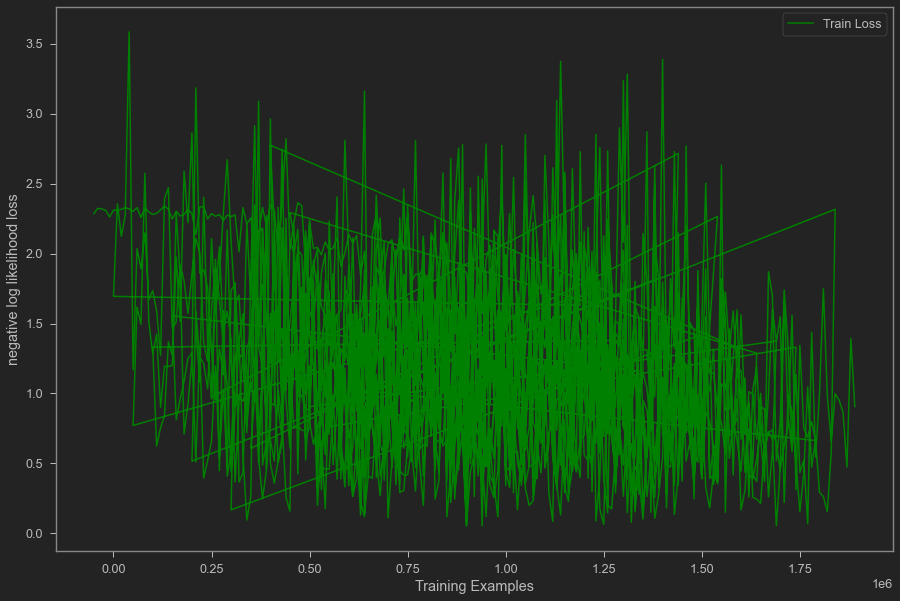

In [37]:
plt.figure(figsize=(15, 10))
plt.tight_layout()
plt.plot(training_counter, training_losses, color='green')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('Training Examples')
plt.ylabel('negative log likelihood loss')

### Evaluating Class Accuracy

In [41]:
correct_classes = list(0. for i in range(10))
total_classes = list(0. for i in range(10))
with torch.no_grad():
    for images, labels in testset:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            correct_classes[label] += c[i].item()
            total_classes[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2f' % (classes[i], 100 * correct_classes[i] / total_classes[i]))

Accuracy of plane : 73.200000
Accuracy of   car : 79.100000
Accuracy of  bird : 54.100000
Accuracy of   cat : 40.400000
Accuracy of  deer : 56.300000
Accuracy of   dog : 65.900000
Accuracy of  frog : 68.300000
Accuracy of horse : 61.700000
Accuracy of  ship : 71.600000
Accuracy of truck : 54.100000


### Confusion Matrix

In [39]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for images, labels in testset:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 62.47%


In [42]:
print('{0:10s} - {1}'.format('Class','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.2f}'.format(classes[i], r[i]/np.sum(r)*100))

Class      - Accuracy
plane      - 73.20
car        - 79.10
bird       - 54.10
cat        - 40.40
deer       - 56.30
dog        - 65.90
frog       - 68.30
horse      - 61.70
ship       - 71.60
truck      - 54.10


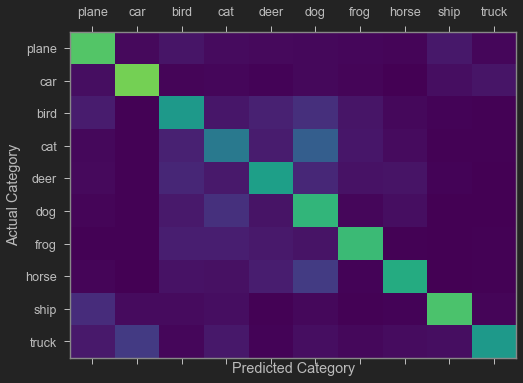

In [43]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('viridis'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [44]:
print('actual/predicted'.ljust(16), end='')
for i,col in enumerate(classes):
    print(col.ljust(10), end='')
print()
for i,row in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(row):
        print(str(p).ljust(10), end='')
    print()
    
    row = row/np.sum(row)
    print(''.ljust(16), end='')
    for idx, p in enumerate(row):
        print(str(p).ljust(10), end='')
    print()

actual/predictedplane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           732       27        55        30        26        20        18        12        64        16        
                0.732     0.027     0.055     0.03      0.026     0.02      0.018     0.012     0.064     0.016     
car             39        791       14        18        10        20        12        3         38        55        
                0.039     0.791     0.014     0.018     0.01      0.02      0.012     0.003     0.038     0.055     
bird            75        4         541       62        92        135       55        23        9         4         
                0.075     0.004     0.541     0.062     0.092     0.135     0.055     0.023     0.009     0.004     
cat             22        6         92        404       76        298       62        29        6         5         
                0.022     0.006     0.092     0.404     0.076   